In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import h5py
import multiprocessing as mp
import os
import sys
sys.path.append('../')
from src.stum import STUM
from src.__init__ import *
import argparse

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rwlinno. Use `wandb login --relogin` to force relogin


In [2]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader as DL
import pickle
import threading
import os

class DataLoader(object):
    def __init__(self, data, idx, seq_len, horizon, bs, pad_last_sample=False):
        if pad_last_sample:
            num_padding = (bs - (len(idx) % bs)) % bs
            idx_padding = np.repeat(idx[-1:], num_padding, axis=0)
            idx = np.concatenate([idx, idx_padding], axis=0)
        
        self.data = data
        self.idx = idx
        self.size = len(idx)
        self.bs = bs
        self.num_batch = int(self.size // self.bs)
        self.current_ind = 0
        self.x_offsets = np.arange(-(seq_len - 1), 1, 1)
        self.y_offsets = np.arange(1, (horizon + 1), 1)
        self.seq_len = seq_len
        self.horizon = horizon

    def shuffle(self):
        perm = np.random.permutation(self.size)
        idx = self.idx[perm]
        self.idx = idx

    def write_to_shared_array(self, x, y, idx_ind, start_idx, end_idx):
        for i in range(start_idx, end_idx):
            x[i] = self.data[idx_ind[i] + self.x_offsets, :, :]
            y[i] = self.data[idx_ind[i] + self.y_offsets, :, :1]

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.bs * self.current_ind
                end_ind = min(self.size, self.bs * (self.current_ind + 1))
                idx_ind = self.idx[start_ind: end_ind, ...]

                x_shape = (len(idx_ind), self.seq_len, self.data.shape[1], self.data.shape[-1])
                x_shared = mp.RawArray('f', int(np.prod(x_shape)))
                x = np.frombuffer(x_shared, dtype='f').reshape(x_shape)

                y_shape = (len(idx_ind), self.horizon, self.data.shape[1], 1)
                y_shared = mp.RawArray('f', int(np.prod(y_shape)))
                y = np.frombuffer(y_shared, dtype='f').reshape(y_shape)

                array_size = len(idx_ind)
                num_threads = len(idx_ind) // 2
                chunk_size = array_size // num_threads
                threads = []
                for i in range(num_threads):
                    start_index = i * chunk_size
                    end_index = start_index + chunk_size if i < num_threads - 1 else array_size
                    thread = threading.Thread(target=self.write_to_shared_array, args=(x, y, idx_ind, start_index, end_index))
                    thread.start()
                    threads.append(thread)

                for thread in threads:
                    thread.join()

                yield (x, y)
                self.current_ind += 1

        return _wrapper()


class StandardScaler():
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)


    def transform(self, data):
        return (data - self.mean) / self.std


    def inverse_transform(self, data):
        return (data * self.std) + self.mean
    
def load_dataset(data_path, args):
    ptr = np.load(os.path.join(data_path, args['years'], 'his.npz'))

    dataloader = {}
    for cat in ['train', 'val', 'test']:
        idx = np.load(os.path.join(data_path, args['years'], 'idx_' + cat + '.npy'))
        dataloader[cat + '_loader'] = DataLoader(ptr['data'][..., :args['input_dim']], idx, \
                                                 args['seq_length'], args['horizon'], args['batch_size'])

    scaler = StandardScaler(mean=ptr['mean'], std=ptr['std'])
    return dataloader, scaler
def load_adj_from_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

def load_adj_from_numpy(numpy_file):
    return np.load(numpy_file)


In [3]:
def visualize_predictions_with_model(dataloader, scaler, model1, model2, nodes, titles, batch_size=32, device='cpu'):
    # 设定子图布局
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))

    # 节点列表
    node_list = nodes
    
    # 获取测试集的迭代器
    test_loader = dataloader['test_loader'].get_iterator()

    for x_batch, y_batch in test_loader:
        for i, node_idx in enumerate(node_list):
            # 选择节点的数据
            x_node = x_batch[:, :, node_idx, :]  # [batch_size, seq_len, features]
            y_node = y_batch[:, :, node_idx, :]  # [batch_size, horizon, features]

            # 转换为模型输入的张量，并移动到指定设备
            x_tensor = torch.tensor(x_batch).to(device)

            # 获取模型预测结果
            with torch.no_grad():
                model1_prediction = model1(x_tensor).cpu().numpy()  # 模型输出 [batch_size, horizon, num_nodes, features]
                model2_prediction = model2(x_tensor).cpu().numpy()  # 模型输出 [batch_size, horizon, num_nodes, features]
            
            # 选择当前节点的预测结果
            model1_prediction_node = model1_prediction[:, :, node_idx, :]
            model2_prediction_node = model2_prediction[:, :, node_idx, :]
            # 反标准化历史数据、真实数据和预测结果
            x_node_inv = scaler.inverse_transform(torch.tensor(x_node)).numpy()
            y_node_inv = scaler.inverse_transform(torch.tensor(y_node)).numpy()
            model1_prediction_node_inv = scaler.inverse_transform(torch.tensor(model1_prediction_node)).numpy()
            model2_prediction_node_inv = scaler.inverse_transform(torch.tensor(model2_prediction_node)).numpy()

            # 选择第一个样本进行可视化
            x_sample = x_node_inv[0, :, 0]  # 第一个样本的第一个特征（假设是流量数据）
            y_sample = y_node_inv[0, :, 0]  # 第一个样本的第一个特征
            model1_prediction_sample = model1_prediction_node_inv[0, :, 0]  # 模型预测的第一个样本
            model2_prediction_sample = model2_prediction_node_inv[0, :, 0]  # 模型预测的第一个样本

            # 生成时间步长
            time_steps = np.arange(len(x_sample) + len(y_sample))

            # 绘制历史数据、真实数据和模型预测结果
            axs[i].plot(time_steps[:len(x_sample)], x_sample, label='History', color='#c16e71', marker='o', linewidth=2, alpha=0.9)
            axs[i].plot(time_steps[len(x_sample):], y_sample, label='Ground Truth', color='#c16e71', marker='x', linestyle='-', linewidth=2, alpha=0.9)
            axs[i].plot(time_steps[len(x_sample):], model1_prediction_sample, label='STUM Prediction', color='#d8a0c1', marker='s', linestyle='--', linewidth=2, alpha=0.9)
            axs[i].plot(time_steps[len(x_sample):], model2_prediction_sample, label='STAE Prediction', color='#9f8db8', marker='s', linestyle='-.', linewidth=2, alpha=0.9)

            # 添加不确定性区域（假设有一个标准差的范围）
#            uncertainty = np.random.randn(len(model_prediction_sample)) * 10  # 随机生成不确定性，可根据实际情况修改
#            axs[i].fill_between(time_steps[len(x_sample):], 
#                                model_prediction_sample - uncertainty, 
#                                model_prediction_sample + uncertainty, 
#                                color='blue', alpha=0.2)

            # 增加分隔线
            axs[i].axvline(x=len(x_sample) - 1, color='gray', linestyle='--', label='Prediction Start')

            # 设置子图标题
            axs[i].set_title(f'Node {node_idx}: {titles[i]}', fontsize=12)
            axs[i].set_xlabel('Time Step', fontsize=10)
            axs[i].set_ylabel('Traffic Flow (vehicles/5min)', fontsize=10)
            axs[i].legend()
            axs[i].set_xticks(np.arange(0, len(time_steps), 2))
            axs[i].grid(True)


        # 仅显示一批次
        break

    # 总体标题
    fig.suptitle('Forecasting visualizations on three datasets.', fontsize=16)
    
    # 调整子图布局
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [4]:
# 假设数据加载的路径和参数
data_path = '../data/pems04/'
args = {
    'years': '2018',
    'input_dim': 3,
    'output_dim': 1,
    'seq_length': 12,
    'horizon': 12,
    'batch_size': 12
}

In [5]:
# 定义参数类
class Model_Args:
    def __init__(self):
        self.device = 'cpu'
        self.node_num = 307  # 节点数量
        self.input_dim = 3  # 输入维度
        self.output_dim = 1  # 输出维度
        self.seq_length = 12  # 序列长度
        self.horizon = 12  # 预测的时间步长
        self.num_nalls = 4  # 层数
        self.num_mlrfs = 2  # MLRF block 数量
        self.supports = None  # 邻接矩阵等支持信息
        self.lrate = 0.001  # 学习率
        self.wdecay = 1e-5  # 权重衰减
        self.embed_dim = 16  # 嵌入维度
        self.mlp = False  # 是否使用 MLP
        self.without_backbone = False  # 是否不使用 backbone

In [6]:
model_args = Model_Args()
model = STUM(backbone=None, args=model_args)
model.load_state_dict(torch.load('pred_stum_model.pt'),strict=False)
model.eval()  # 将模型设置为评估模式

STUM(
  (dropout): Dropout(p=0.3, inplace=False)
  (blocks): ModuleList(
    (0-1): 2 x MLRF(
      (nalls_spatial): ModuleList(
        (0-3): 4 x ASTUC(
          in_features=4912, out_features=4912, bias=True
          (lora_dropout): Dropout(p=0.3, inplace=False)
        )
      )
      (nalls_temporal): ModuleList(
        (0-3): 4 x ASTUC(
          in_features=192, out_features=192, bias=True
          (lora_dropout): Dropout(p=0.3, inplace=False)
        )
      )
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (norm): RMSNorm()
    )
  )
  (gate): Linear(in_features=4, out_features=1, bias=True)
  (adp_extractor): ASTUC(
    in_features=921, out_features=4912, bias=True
    (lora_dropout): Dropout(p=0.3, inplace=False)
  )
  (adp_predictor): ASTUC(
    in_features=4912, out_features=307, bias=True
    (lora_dropout): Dropout(p=0.3, inplace=False)
  )
  (fc_extractor): Linear(in_fea

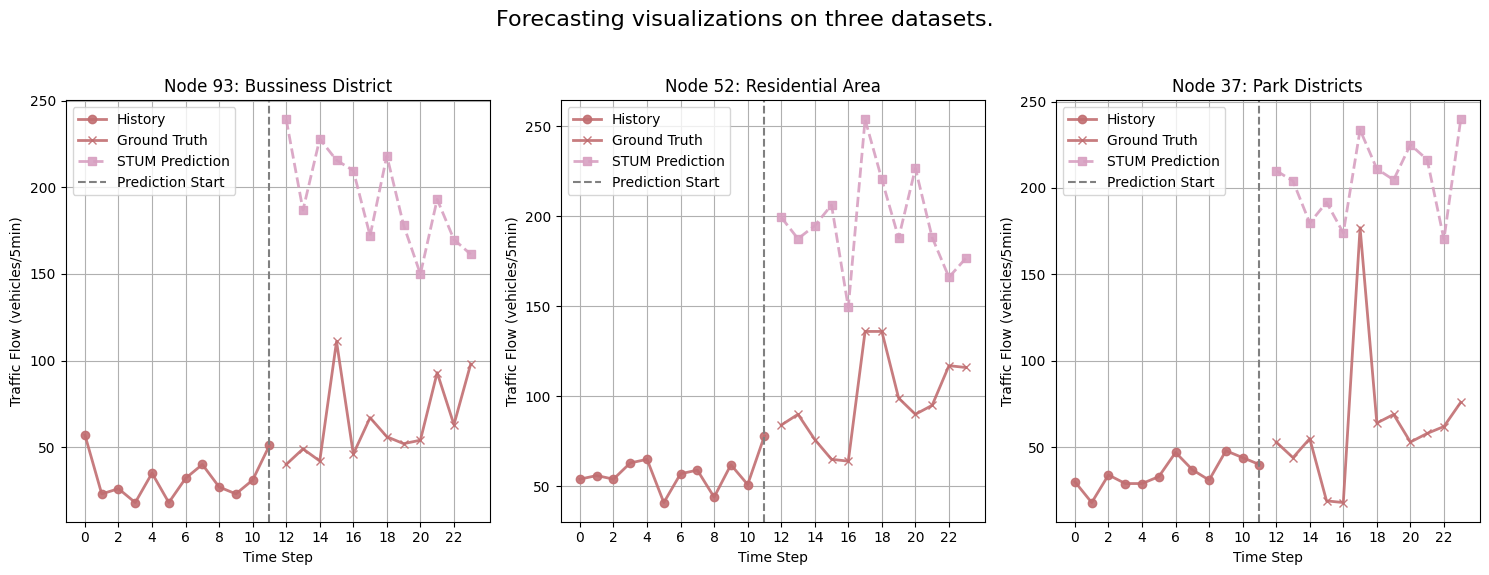

In [7]:
# 可视化第37个节点的历史数据和预测结果
dataloader, scaler = load_dataset(data_path, args)
# 示例调用
nodes = [93, 52, 37]  # 示例节点
titles = ['Bussiness District', 'Residential Area', 'Park Districts']  # 示例节点名称
# 使用模型进行可视化
visualize_predictions_with_model(dataloader, scaler, model, nodes=nodes, titles=titles, batch_size=12, device='cpu')